In [2]:
#Final Project
# Add names
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

In [3]:
# Read data to file, and verify 
data = pd.read_csv('suicide.csv')
data.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


In [4]:
#Drop country-year variable and rename columns. change gdp to numeric
data = data.drop(['country-year'],axis=1)
data.columns = ['country','year','sex','age','suicides','population',
              '100k_suicides','HDI','gdp','gdp_capita','generation']
data['gdp'] = pd.to_numeric([a['gdp'].replace(',','') for b,a in data.iterrows()])
data.head(10)

,country,year,sex,age,suicides,population,100k_suicides,HDI,gdp,gdp_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,NaN,2156624900,796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,NaN,2156624900,796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,NaN,2156624900,796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,NaN,2156624900,796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,NaN,2156624900,796,Generation X


In [5]:
# We want to find the percentage of the total population for a given group
data['population_est'] = data['population']/(data['gdp']/data['gdp_capita'])
data['total_suicide'] = data['100k_suicides'] * 1000
data.head(10)

,country,year,sex,age,suicides,population,100k_suicides,HDI,gdp,gdp_capita,generation,population_est,total_suicide
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X,0.115490,6710.0
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent,0.113681,5190.0
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X,0.106927,4830.0
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation,0.008046,4590.0
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers,0.101243,3280.0
5,Albania,1987,female,75+ years,1,35600,2.81,NaN,2156624900,796,G.I. Generation,0.013140,2810.0
6,Albania,1987,female,35-54 years,6,278800,2.15,NaN,2156624900,796,Silent,0.102904,2150.0
7,Albania,1987,female,25-34 years,4,257200,1.56,NaN,2156624900,796,Boomers,0.094931,1560.0
8,Albania,1987,male,55-74 years,1,137500,0.73,NaN,2156624900,796,G.I. Generation,0.050751,730.0
9,Albania,1987,female,5-14 years,0,311000,0.00,NaN,2156624900,796,Generation X,0.114789,0.0


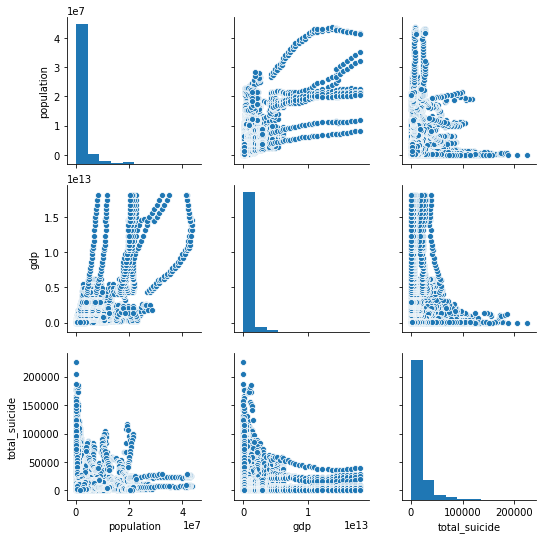

In [6]:
# will visualize only a couple variables
dat = data[['population','gdp','total_suicide']]
sns.pairplot(dat)

In [7]:
data.describe()

,year,suicides,population,100k_suicides,HDI,gdp,gdp_capita,population_est,total_suicide
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,2.782000e+04,27820.000000,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,4.455810e+11,16866.464414,0.083357,12816.097412
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,1.453610e+12,18887.576472,0.040477,18961.511015
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,4.691962e+07,251.000000,0.000892,0.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,8.985353e+09,3447.000000,0.058681,920.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,4.811469e+10,9372.000000,0.082433,5990.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,2.602024e+11,24874.000000,0.109253,16620.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,1.812071e+13,126352.000000,0.309876,224970.000000


In [8]:
#Plot by generation,  not very useful really but.plot(x='year',y='100k_suicides')
data.groupby(['generation','year']).mean()

suicides    population  100k_suicides       HDI  \
generation year                                                      
Boomers    1985  216.364583  1.807673e+06      10.008750  0.699162   
           1986  225.885417  1.835571e+06      10.593854       NaN   
           1987  206.564815  1.749894e+06      10.960370       NaN   
           1988  217.673469  1.856479e+06      12.410102       NaN   
           1989  282.951923  2.053524e+06      12.178173       NaN   
           1990  275.593750  1.999559e+06      12.358828  0.715800   
           1991  406.207031  2.537098e+06      13.520195       NaN   
           1992  433.880769  2.627739e+06      14.109154       NaN   
           1993  460.438462  2.568419e+06      14.693731       NaN   
           1994  462.985294  2.502981e+06      14.303419       NaN   
           1995  575.333333  2.782067e+06      18.566731  0.736429   
           1996  592.727273  2.954341e+06      18.384091       NaN   
           1997  571.506494  3.030171e+06      17.652727       NaN   
           1998  579.917722  3.029512e+06      17.877532       NaN   
           1999  579.656627  3.013112e+06      17.409699       NaN   
           2000  568.686047  2.979105e+06      16.443372  0.752961   
           2001  551.125000  2.859685e+06      16.433750       NaN   
           2002  573.691860  3.051699e+06      16.228721       NaN   
           2003  573.796512  3.087978e+06      16.077151       NaN   
           2004  550.779762  3.032861e+06      15.013095       NaN   
           2005  526.773810  3.020510e+06      14.346131  0.779434   
           2006  511.952941  3.155952e+06      14.063176       NaN   
           2007  498.540698  3.156281e+06      13.747326       NaN   
           2008  509.788235  3.192878e+06      14.423941       NaN   
           2009  507.808989  3.231707e+06      14.079663       NaN   
           2011  344.058140  2.136814e+06      13.766163  0.795778   
           2012  360.759259  2.254825e+06      14.354691  0.804526   
           2013  360.600000  2.280820e+06      14.360250  0.808312   
           2014  369.846154  2.397683e+06      13.773269  0.808520   
           2015  432.161290  2.859404e+06      14.451774       NaN   
...                     ...           ...            ...       ...   
Silent     1987  376.379630  2.532160e+06      12.383611       NaN   
           1988  395.612245  2.727185e+06      13.176020       NaN   
           1989  514.817308  3.044496e+06      13.584519       NaN   
           1990  509.703125  2.979914e+06      13.975234  0.715800   
           1991  377.460938  1.884916e+06      16.436094       NaN   
           1992  396.200000  1.938330e+06      17.097769       NaN   
           1993  417.523077  1.932532e+06      17.262923       NaN   
           1994  416.000000  1.901993e+06      17.249118       NaN   
           1995  379.089744  1.716768e+06      19.534936  0.736429   
           1996  389.474026  1.794557e+06      19.642987       NaN   
           1997  380.987013  1.799288e+06      18.807597       NaN   
           1998  390.139241  1.779761e+06      19.098165       NaN   
           1999  377.493976  1.744647e+06      18.389398       NaN   
           2000  354.494186  1.697288e+06      17.531279  0.752961   
           2001  228.619318  1.065608e+06      20.836335       NaN   
           2002  240.502907  1.135373e+06      21.519419       NaN   
           2003  243.901163  1.161331e+06      20.524738       NaN   
           2004  236.809524  1.173664e+06      19.330923       NaN   
           2005  235.229167  1.184759e+06      18.683393  0.779434   
           2006  233.576471  1.237099e+06      18.711176       NaN   
           2007  233.668605  1.255608e+06      18.767064       NaN   
           2008  238.947059  1.291749e+06      18.374706       NaN   
           2009  234.230337  1.302231e+06      17.351320       NaN   
           2010  237.434659  1.352472e+06      17.107642  0.793869   
           2011  140.750000  

In [9]:
#Lets get the mean 100k_suicide by generaiton (regardless of country) and see if these change throughout the years
data.groupby(['generation'])

In [10]:
data1 = data.groupby(['country','year']).sum()
data1.head()

suicides  population  100k_suicides  HDI          gdp  \
country year                                                          
Albania 1987        73     2709600          31.85  0.0  25879498800   
        1988        63     2764300          32.46  0.0  25512000000   
        1989        68     2803100          33.40  0.0  28021499856   
        1992        47     2822500          18.00  0.0   8513431008   
        1993        73     2807300          32.56  0.0  14736852456   

              gdp_capita  population_est  total_suicide  
country year                                             
Albania 1987        9552        1.000100        31850.0  
        1988        9228        0.999881        32460.0  
        1989        9996        0.999939        33400.0  
        1992        3012        0.998583        18000.0  
        1993        5244        0.998957        32560.0

In [172]:
total = pd.DataFrame(data['total_suicide'].groupby([data['year'],data['generation'],data['sex']]).sum()).reset_index()
total.head()
#print(total[(total['generation']=='Boomers') & (total['sex']=='male') & (total['year']==1985) ])

,year,generation,sex,total_suicide
0,1985,Boomers,female,227530.0
1,1985,Boomers,male,733310.0
2,1985,G.I. Generation,female,912020.0
3,1985,G.I. Generation,male,2887530.0
4,1985,Generation X,female,244270.0


In [173]:
#We need to fix some and add counts before (for millenials and gen z we need to add 0s before)
gens = ['Millenials','Generation Z','G.I. Generation']
for g in gens:
    for y in range(1985,2017,1):
        temp = total[(total['generation']==g) & (total['sex']=='male')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'male','total_suicide':0} , ignore_index=True)
        temp = total[(total['generation']==g) & (total['sex']=='female')]['year']
        if int(y) not in np.array(temp):
            total = total.append({'year':int(y),'generation':g,'sex':'female','total_suicide':0} , ignore_index=True)
#Boomers are missing 2010
totalm = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='male')]['total_suicide']) + 
          int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='male')]['total_suicide']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'male','total_suicide':totalm} , ignore_index=True)
totalf = (int(total[(total['generation']=='Boomers') & (total['year']==2009) & (total['sex']=='female')]['total_suicide']) + 
          int(total[(total['generation']=='Boomers') & (total['year']==2011) & (total['sex']=='female')]['total_suicide']))/2
total = total.append({'year':2010,'generation':'Boomers','sex':'female','total_suicide':totalf} , ignore_index=True)

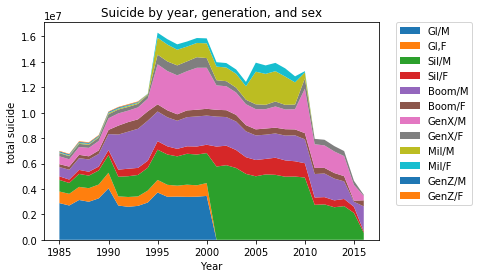

In [142]:
#Print total suciide by generation and gender
plt.stackplot(range(1985,2017),total[(total['sex']=='male') & (total['generation']=='G.I. Generation')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='G.I. Generation')]['total_suicide'],
total[(total['sex']=='male') & (total['generation']=='Silent')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='Silent')]['total_suicide'],
total[(total['sex']=='male') & (total['generation']=='Boomers')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='Boomers')]['total_suicide'],
total[(total['sex']=='male') & (total['generation']=='Generation X')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='Generation X')]['total_suicide'],
total[(total['sex']=='male') & (total['generation']=='Millenials')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='Millenials')]['total_suicide'],
total[(total['sex']=='male') & (total['generation']=='Generation Z')]['total_suicide'],
total[(total['sex']=='female') & (total['generation']=='Generation Z')]['total_suicide'],)
plt.title('Suicide by year, generation, and sex')
plt.legend('Generation and sex')
plt.ylabel('total suicide')
plt.xlabel('Year')
plt.legend(['GI/M','GI,F','Sil/M','Sil/F','Boom/M','Boom/F',
            'GenX/M','GenX/F','Mil/M','Mil/F','GenZ/M','GenZ/F'],bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)

(0, 1)

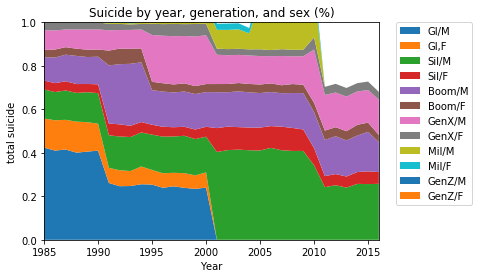

In [165]:
#Same thing but doing percentage,. I am not sure what is wrong with this plot, maybe we should discontinue...
total1 = total
for i in range(1985,2017,1):
    total1.loc[total1['year']==int(i),'total_suicide'] = total1[total1['year']==int(i)]['total_suicide']/sum(total1[total1['year']==int(i)]['total_suicide'])
# % plot    
plt.stackplot(range(1985,2017),total1[(total1['sex']=='male') & (total1['generation']=='G.I. Generation')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='G.I. Generation')]['total_suicide'],
total1[(total1['sex']=='male') & (total1['generation']=='Silent')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='Silent')]['total_suicide'],
total1[(total1['sex']=='male') & (total1['generation']=='Boomers')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='Boomers')]['total_suicide'],
total1[(total1['sex']=='male') & (total1['generation']=='Generation X')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='Generation X')]['total_suicide'],
total1[(total1['sex']=='male') & (total1['generation']=='Millenials')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='Millenials')]['total_suicide'],
total1[(total1['sex']=='male') & (total1['generation']=='Generation Z')]['total_suicide'],
total1[(total1['sex']=='female') & (total1['generation']=='Generation Z')]['total_suicide'],)
plt.margins(0,0)
plt.title('Suicide by year, generation, and sex (%)')
plt.legend('Generation and sex')
plt.ylabel('total suicide')
plt.xlabel('Year')
plt.legend(['GI/M','GI,F','Sil/M','Sil/F','Boom/M','Boom/F',
            'GenX/M','GenX/F','Mil/M','Mil/F','GenZ/M','GenZ/F'],bbox_to_anchor=(1.05, 1),loc=2,borderaxespad=0.)
plt.ylim([0,1])

In [239]:
total1 = pd.DataFrame(data['100k_suicides'].groupby([data['year'],data['generation'],data['sex']]).sum()).reset_index()
total2 = pd.get_dummies(total1)
#total2.drop(['sex_male','generation_Generation Z'], axis=1)
total2.columns = total2.columns.str.replace(' ', '')
total2.columns = total2.columns.str.replace('.', '')
total2.loc[:,'100k_suicides'] = (total2['100k_suicides']-np.mean(total2['100k_suicides']))/np.std(total2['100k_suicides'])
total2.columns = total2.columns.str.replace('100k_suicides', 'target')
a = 'target ~ ' + ' + '.join(total2.columns[2:])
outcome_1, predictors_1 = patsy.dmatrices(a,total2)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     58.53
Date:                Sat, 02 Mar 2019   Prob (F-statistic):           6.49e-47
Time:                        13:08:56   Log-Likelihood:                -297.10
No. Observations:                 292   AIC:                             608.2
Df Residuals:                     285   BIC:                             633.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [238]:
print(min(total2['year']))

1985


In [ ]:
shortlist = ['Argentina','Canada','Mexico','Australia']
data1 = data[data['country'] in shortlist]
g = sns.FacetGrid(data1, col="total_suicide",  row="year",hue='generation')
#g = g.map(plt.hist, "country")

In [ ]:
#simple model total suicide and total gdp
a1,a2 = np.polyfit(data['gdp'],data['total_suicide'],1)

In [ ]:
x_vals = data['gdp']
y_vals = a1 * x_vals + a2
plt.scatter(x_vals,data['total_suicide'])
plt.plot(x_vals,y_vals,'ro' )

In [ ]:
#Looking at the above plot, we can see that suicides are high on low GDP, and overall lower at higher GDP.
#linear relationship is not the best, and this model is a poor predictor. Lets try using a second order

In [13]:
b1,b2,b3 = np.polyfit(data['gdp'],data['total_suicide'],2)

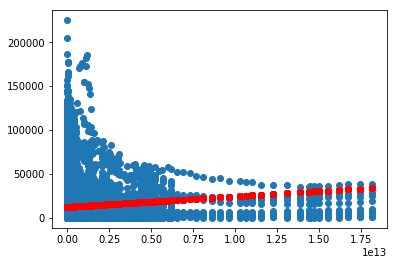

In [14]:
x_vals = data['gdp']
y_vals = b1 * np.power(x_vals,2) + b2 * x_vals + b3
plt.scatter(x_vals,data['total_suicide'])
plt.plot(x_vals,y_vals,'ro' )

In [15]:
#We also obtained a poor model here just by looking at it. I think this shows an overall trend, but not a good model

In [16]:
#simple model total suicide and total gdp
c1,c2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['total_suicide'][~np.isnan(data['HDI'])],1)

In [ ]:
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = c1 * x_vals + c2
plt.scatter(x_vals,data['total_suicide'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )

In [ ]:
#So despite HDI going up, suicide is going up. why?
# The story is not as simple. and there is actually something important missing
# When we get the HDI, we actually have no idea of the population size. We are measuring with overall suicide
# and get no information abou thhe total population size. In fact, you may see that the line is going up with happiness
# index. This may be because happier countries tend to be bigger and not because happier countries have higher suicuide,
# lets actually see this

In [ ]:
d1, d2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['population'][~np.isnan(data['HDI'])],1)
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = d1 * x_vals + d2
plt.scatter(x_vals,data['population'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )


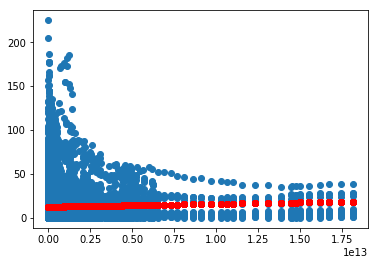

In [14]:
# Lets use suicide rate instead and see the differences.
b1,b2 = np.polyfit(data['gdp'],data['100k_suicides'],1)
x_vals = data['gdp']
y_vals = b1 * x_vals + b2
plt.scatter(x_vals,data['100k_suicides'])
plt.plot(x_vals,y_vals,'ro' )

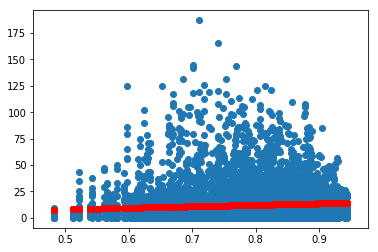

In [15]:
d1, d2 = np.polyfit(data['HDI'][~np.isnan(data['HDI'])],data['100k_suicides'][~np.isnan(data['HDI'])],1)
x_vals = data['HDI'][~np.isnan(data['HDI'])]
y_vals = d1 * x_vals + d2
plt.scatter(x_vals,data['100k_suicides'][~np.isnan(data['HDI'])])
plt.plot(x_vals,y_vals,'ro' )

In [1]:
#We get a somewhat better relationship, but not quite something good

3.7.1 | packaged by conda-forge | (default, Feb 25 2019, 21:02:05) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [ ]:
# Grab other Data
data = pd.read_csv('Data.csv')
data.head(10)